In [310]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [311]:
def initialize_membership_matrix(num_samples, num_clusters):
    membership_mat = np.random.rand(num_clusters, num_samples)
    membership_mat /= np.sum(membership_mat, axis=0)
    return membership_mat

def initial_centroids(num_clusters, num_features):
    return np.random.rand(num_clusters, num_features)
    

In [312]:
def epsilon_insensitive_loss(y_true, y_pred, epsilon):
    # Calculate absolute errors
    errors = np.linalg.norm(np.abs(y_true - y_pred))
    # Apply epsilon-insensitive penalty
    loss = np.maximum(0, errors - epsilon)
    return loss

In [313]:
def update_membership_matrix(data, centroids, num_clusters, epsilon, m):
    # Update the membership matrix
    num_samples = data.shape[0]
    membership_mat = np.zeros((num_clusters, num_samples)).astype('float128')
    for i in range(num_samples):
        denominator = np.sum(epsilon_insensitive_loss(data[i], centroids, epsilon)**(1/(1-m))) 
        for k in range(num_clusters):
            membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-20)
            if np.isinf(membership_mat[k, i]):
                membership_mat[k, i] = 1
    membership_mat /= np.sum(membership_mat, axis=0)
    return membership_mat

In [314]:
from scipy.optimize import minimize
import random

EPSILON = .01
DATA = None
L    = None


def objective(x):
    global EPSILON 
    global DATA
    global L
    a = x[:len(x)//2]
    b = x[len(x)//2:]
    temp = 0
    for k in range(len(a)):
        temp += (a[k] - b[k])*DATA[k,L]
    return temp + sum(a + b) * EPSILON

def constraint(x):
    a = x[:len(x)//2]
    b = x[len(x)//2:]
    return sum(a) - sum(b)

def Lambda(num_samples, membership_mat, i_index, m):
    initial_guess_a = [0. for j in range(num_samples)] 
    initial_guess_b = [0. for j in range(num_samples)]
    initial_guess = np.concatenate((initial_guess_a, initial_guess_b))
    bounds_a = [(0, membership_mat[i_index, j]**m) for j in range(num_samples)]
    bounds_b = [(0, membership_mat[i_index, j]**m) for j in range(num_samples)]
    bounds = np.concatenate((bounds_a, bounds_b))
    constraint_eq = {'type': 'eq', 'fun': constraint}
    result = minimize(objective, initial_guess, bounds=bounds, constraints=constraint_eq)

    return result.x[:len(result.x)//2], result.x[len(result.x)//2:]

def update_centroid(data, num_samples, num_features, num_clusters, centroids, epsilon, membership_mat, m):
    global EPSILON, DATA, L
    EPSILON = epsilon
    DATA = data
    for i in range(num_clusters):
        for j in range(num_features):
            L = j
            l1, l2 = Lambda(num_samples, membership_mat, i, m)
            f, s = 0., 0.
            for ns in range(num_samples):
                if 0<l1[ns]<membership_mat[i, ns]:
                    f += data[ns][j] + epsilon
                if 0<l2[ns]<membership_mat[i, ns]:
                    s += data[ns][j] - epsilon
            # print(f, end=":")
            # print(s)
            centroids[i][j] = 1.1*(f+s) / np.unique(np.concatenate((l1, l2))).shape[0]
    
    return centroids
        

In [315]:
from sklearn.metrics import normalized_mutual_info_score

def fuzzy_cmeans(data, num_clusters, max_iter, epsilon, m, y=None):
    history_mem, history_cent, history_nmi = [], [], []
    num_samples, num_features = data.shape
    cen_mat = initial_centroids(num_clusters, num_features)
    for _ in range(max_iter):
        print(_, end=':')
        mem_mat = update_membership_matrix(data, cen_mat, num_clusters, epsilon, m)
        cen_mat = update_centroid(data, num_samples, num_features, num_clusters, cen_mat, epsilon, mem_mat, m)
        if y is not None:
            max_membership_cluster = np.argmax(mem_mat, axis=0)
            nmi = normalized_mutual_info_score(y, max_membership_cluster)
            history_mem.append(mem_mat)
            history_cent.append(cen_mat)
            history_nmi.append(nmi)
            # if nmi > .9:
            #     return cen_mat, mem_mat
            print("Normalized Mutual Information (NMI):", nmi)
    
    max_index = np.argmax(history_nmi)
    print(cen_mat)
    print(mem_mat)
    return history_cent[max_index], history_mem[max_index]
        

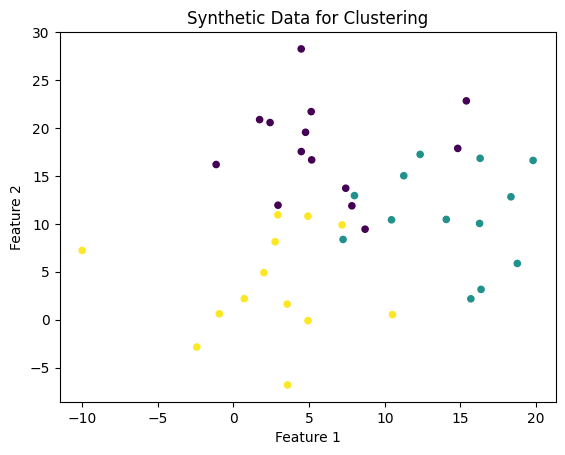

0:Normalized Mutual Information (NMI): 0.1197232515494881
1:Normalized Mutual Information (NMI): 0.38658640251113774
2:Normalized Mutual Information (NMI): 0.5316575925982618
3:Normalized Mutual Information (NMI): 0.41386122013463056
4:Normalized Mutual Information (NMI): 0.1839371321896323
5:Normalized Mutual Information (NMI): 0.35898256879404006
6:Normalized Mutual Information (NMI): 0.34472540120429807
7:Normalized Mutual Information (NMI): 0.3593768618083667
8:Normalized Mutual Information (NMI): 0.407531268270329
9:Normalized Mutual Information (NMI): 0.32862776831841983
10:Normalized Mutual Information (NMI): 0.30267272248655347
11:Normalized Mutual Information (NMI): 0.4127983722991657
12:Normalized Mutual Information (NMI): 0.25821932740886666
13:Normalized Mutual Information (NMI): 0.4061058624193218
14:Normalized Mutual Information (NMI): 0.21478989507267307
15:Normalized Mutual Information (NMI): 0.4295324039405653
16:Normalized Mutual Information (NMI): 0.4427678135906677


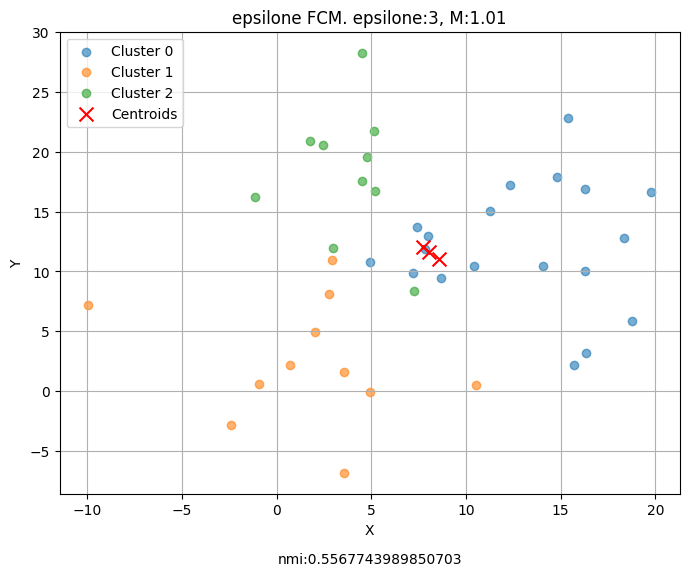

In [320]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import normalized_mutual_info_score



num_clusters = 3
num_samples = 40
m = 1.01
epsilon = 3
# Generate synthetic data with clusters
X, y = make_blobs(n_samples=num_samples, centers=num_clusters, cluster_std=5, random_state=42)
X += 10



# Visualize the generated data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=20)
plt.title('Synthetic Data for Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


centroids ,membership_mat = fuzzy_cmeans(data=X, num_clusters=num_clusters, max_iter=20, epsilon=epsilon, m=m, y=y)

max_membership_cluster = np.argmax(membership_mat, axis=0)
# Plot data points with colors based on their corresponding centroids
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    cluster_data = X[max_membership_cluster == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.title(f'epsilone FCM. epsilone:{epsilon}, M:{m}')
plt.xlabel('X')
plt.ylabel('Y')

# Assuming 'y' contains the true cluster labels and 'max_membership_cluster' contains the cluster labels assigned by your fuzzy clustering algorithm
nmi = normalized_mutual_info_score(y, max_membership_cluster)
print("Normalized Mutual Information (NMI):", nmi)

plt.text(0.5, -0.15, f'nmi:{nmi}', ha='center', transform=plt.gca().transAxes)

plt.legend()
plt.grid(True)
plt.show()